In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%%capture
!pip install indic-nlp-library

In [2]:
%pip install torch==2.3.0+cu121 torchtext==0.18.0+cpu -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached 

In [1]:
print("OK!")

OK!


In [1]:
import torch
import torch.nn.functional as F
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.nn.functional import one_hot
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

import os
import re
from pathlib import Path
import unicodedata
import pandas as pd
import matplotlib.pyplot as plt
from indicnlp.tokenize.sentence_tokenize import sentence_split
from indicnlp.tokenize.indic_tokenize import trivial_tokenize_urdu
import time

c:\Users\Home\anaconda3\envs\E_to_U\lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\Home\anaconda3\envs\E_to_U\lib\site-packages\torchtext\vocab\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\Home\anaconda3\envs\E_to_U\lib\site-packages\torchtext\utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TOR

In [2]:
# prompt: print versions

print('torchtext version:', torchtext.__version__)
print('torch version:', torch.__version__)


torchtext version: 0.18.0+cpu
torch version: 2.3.0+cpu


In [15]:
%pwd

'g:\\CampusX\\Onsite Projects\\Pytorch-NMT\\Neural_Machine_Translation\\Eng_to_Urdu_Translation'

In [13]:
!cd "notebooks"

In [16]:

df = pd.read_csv(r'G:\CampusX\Onsite Projects\Pytorch-NMT\Neural_Machine_Translation\Eng_to_Urdu_Translation\data\eng-to-Urdu-pairs\English_Urdu_pairs.csv')

df.columns


Index(['English', 'Urdu'], dtype='object')

In [25]:
df[['English']].to_csv(r'G:\CampusX\Onsite Projects\Pytorch-NMT\Neural_Machine_Translation\Eng_to_Urdu_Translation\data\english\english.csv', index=False)
df[['Urdu']].to_csv(r'G:\CampusX\Onsite Projects\Pytorch-NMT\Neural_Machine_Translation\Eng_to_Urdu_Translation\data\urdu\urdu.csv', index=False)


In [26]:
en_filepath = r'G:\CampusX\Onsite Projects\Pytorch-NMT\Neural_Machine_Translation\Eng_to_Urdu_Translation\data\english\english.csv'
ur_filepath = r'G:\CampusX\Onsite Projects\Pytorch-NMT\Neural_Machine_Translation\Eng_to_Urdu_Translation\data\urdu\urdu.csv'

with open(en_filepath, "r", encoding='utf-8') as f:
  english_data = f.readlines()

with open(ur_filepath, "r", encoding='utf-8') as f:
  urdu_data = f.readlines()

In [27]:
print(f"English data: {len(english_data)}")
print(f"Urdu data: {len(urdu_data)}")


English data: 26873
Urdu data: 26872


In [28]:
req_urdu = urdu_data[1:26860]
req_english = english_data[1:26860]
data = {"english_txt":req_english,"urdu_txt":req_urdu}

df = pd.DataFrame(data)

In [29]:
df.sample(5)

,english_txt,urdu_txt
24592,you are very funny\n,تم مذاحیہ ہو!\n
6868,he is aggressive\n,وہ جارحانہ ہے\n
13047,Can you recommend a good place to eat?\n,کیا آپ کوئی اچھا کھانے کی جگہ تجویز کر سکتے ہی...
19880,are you sick of me\n,کیا آپ مجھ سے بیمار ہیں؟\n
20735,how was your day\n,آپ کا دن کیسا گزرا\n


In [30]:
df.shape

(26859, 2)

In [31]:
df.columns

Index(['english_txt', 'urdu_txt'], dtype='object')

In [32]:
# Handling the encoding issue by removing the rows.

def is_urdu_corrupted(text):
    """
    Checks if a given text contains characters outside the typical Urdu script range.

    Args:
        text (str): The text to be checked.

    Returns:
        bool: True if the text contains characters outside the Urdu range, False otherwise.
    """
    if re.search(r'[^\u0900-\u097F\s,.?!\u0600-\u06FF]', text):  # Expanded range for punctuation
        return True  # Text contains characters outside Urdu range
    return False  # Text is likely within Urdu range

In [33]:
# Apply the function to the 'Hindi' column to create a mask
df['Corrupted'] = df['urdu_txt'].apply(is_urdu_corrupted)

# Filter out corrupted rows
df_clean = df[~df['Corrupted']]

# Drop the 'Corrupted' column as it's no longer needed
df_clean = df_clean.drop(columns=['Corrupted'])

In [34]:
df_clean.shape

(26727, 2)

In [35]:
df_clean.columns

Index(['english_txt', 'urdu_txt'], dtype='object')

In [36]:
def clean_text(text, language="english"):
    # Normalize unicode characters
    text = unicodedata.normalize('NFKC', text)
    # Convert to lowercase if the text is in English
    if language == "english":
        text = text.lower()
    # Remove any English words present in Urdu text.
    if language == "urdu":
        text = re.sub('[a-zA-Z]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [37]:
df_clean["english_txt"] = df_clean["english_txt"].apply(clean_text)
df_clean["urdu_txt"] = df_clean['urdu_txt'].apply(clean_text, args=("urdu",))

In [38]:
df_clean.sample(10)

,english_txt,urdu_txt
8699,i have no future,میرا کوئی مستقبل نہیں ہے
22057,materials,مواد
7046,have fun this summer,اس موسم گرما میں مزہ کریں
5323,you cant help me,تم میری مدد نہیں کر سکتے
10193,opinion,رائے
10051,public opinion,عوامی رائے
26551,you have not done anything so far,غور سے سنیں کہ کیا کرنے کی ضرورت ہے
11059,do you eat out often,کیا آپ اکثر باہر کھاتے ہیں
21956,please step inside,براہ کرم اندر قدم رکھیں
13774,he loves to gossip,وہ گپ شپ سے محبت کرتا ہے


In [39]:
df_clean['English_Words'] = df_clean['english_txt'].apply(lambda x: len(x.split()))
df_clean['Urdu_Words'] = df_clean['urdu_txt'].apply(lambda x: len(x.split()))

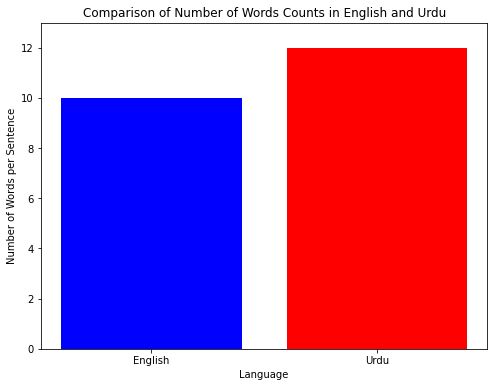

In [40]:
# Calculate averages
average_english_words = df_clean['English_Words'].quantile(.99)
average_hindi_words = df_clean['Urdu_Words'].quantile(.99)

# Data for plotting
averages = [average_english_words, average_hindi_words]
languages = ['English', 'Urdu']

# Creating the plot
plt.figure(figsize=(8, 6))
plt.bar(languages, averages, color=['blue', 'red'])
plt.xlabel('Language')
plt.ylabel('Number of Words per Sentence')
plt.title('Comparison of Number of Words Counts in English and Urdu')
plt.ylim(0, max(averages) + 1)  # Adjust y-axis for better visualization
plt.show()

# Torchtext
Torchtext is a library within the PyTorch ecosystem designed to facilitate the preprocessing of textual data.

## get_tokenizer
. The get_tokenizer function is one of the core utilities provided by torchtext for tokenizing text data.

. get_tokenizer retrieves a tokenizer function based on the method specified. This tokenizer can then be used to convert strings of text into lists of tokens.
##Parameters
  
  tokenizer: This argument specifies the type of tokenizer to use. You can specify built-in tokenizers such as "basic_english", "spacy", "moses", or even provide a custom tokenizer function.

  language: Some tokenizers, like those based on the Moses or Spacy libraries, might require you to specify the language of the text, which influences how the text is tokenized (e.g., handling language-specific punctuation and splitting rules).

In [41]:
import indicnlp
trivial_tokenize_urdu
# Sample Urdu sentence
urdu_text = "زین میری طرف دیکھ رہا ہے"

# Tokenizing into words
word_tokens = indicnlp.tokenize.indic_tokenize.trivial_tokenize_urdu(urdu_text)
print("Word Tokens:", word_tokens)




Word Tokens: ['زین', 'میری', 'طرف', 'دیکھ', 'رہا', 'ہے']


In [42]:
# If you have multiple sentences, you can also tokenize into sentences
# Example with multiple sentences
urdu_text_multi = "زین میری طرف دیکھ رہا ہے۔ یہ ایک خوبصورت دن ہے۔"
sentence_tokens = indicnlp.tokenize.sentence_tokenize.sentence_split(urdu_text_multi, lang='hi')
print("Sentence Tokens:", sentence_tokens)

Sentence Tokens: ['زین میری طرف دیکھ رہا ہے۔ یہ ایک خوبصورت دن ہے۔']


In [43]:
tokenizer_eng = get_tokenizer('basic_english')
tokenizer_urd = trivial_tokenize_urdu # This is the Hindi(Urdu) tokenizer from Indic NLP

tokenized_english_txt = [tokenizer_eng(english_sen) for english_sen in df_clean['english_txt'] ]
tokenized_urdu_txt = [tokenizer_urd(urdu_sen) for urdu_sen in df_clean['urdu_txt'] ]

In [44]:
print(tokenized_english_txt[44])
print(tokenized_urdu_txt[44])

['it', 'was', 'cold']
['یہ', 'ٹھنڈا', 'تھا']


## build_vocab_from_iterator
`build_vocab_from_iterator` function in the torchtext.vocab module is used to create a vocabulary from an iterable of tokenized data. This vocabulary is essential for converting textual data into numerical form.

#Parameters:
##tokenized_conv (iterator):
This is the main data input to the function. It should be an iterator (like a `generator` or a `list`) that yields sequences of tokens. Each sequence represents a document or an example in your dataset.
##min_freq (int, optional):
 This parameter specifies the minimum frequency a token must have to be included in the vocabulary. Tokens that appear fewer than min_freq times are excluded from the vocabulary. This is useful for removing rare words which might be typos or irrelevant to most analyses.
##specials (list of str, optional):
 This is a list of special tokens that you want to add to the vocabulary. Common special tokens include:
'<pad>': A padding token used to equalize the lengths of sequences.
'<oov>' (or '<unk>' for "unknown"): A token used to represent out-of-vocabulary words during inference, or when a word appears that is not in the training vocabulary.
##special_first (bool, optional):
 Determines the ordering of special tokens in the vocabulary. If True, special tokens are added at the beginning of the vocabulary. This can be helpful for certain models where token indices are significant (e.g., models using embedding layers might have specific handling for lower indices).

In [45]:
# Step 3: Building Vocabulary
features_vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_english_txt, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
target_vocab = torchtext.vocab.build_vocab_from_iterator(tokenized_urdu_txt, specials=['<unk>', '<pad>', '<bos>', '<eos>'])

features_vocab.set_default_index(features_vocab['<unk>'])
target_vocab.set_default_index(target_vocab['<unk>'])

In [46]:
features_vocab_total_words = len(features_vocab)
target_vocab_total_words = len(target_vocab)

In [47]:
print(features_vocab_total_words)  #English
print(target_vocab_total_words)    #Hindi

6427
6021


In [48]:
features_vocab['<bos>']

2

In [49]:
print(features_vocab_total_words)
print(target_vocab_total_words)

6427
6021


In [50]:
def tokens_to_indices(tokenized_texts, vocab):
    indices_texts = []
    for sentence in tokenized_texts:
        indices_texts.append([vocab[token] for token in sentence if token in vocab])
    return indices_texts

In [51]:
english_indices = tokens_to_indices(tokenized_english_txt, features_vocab)
urdu_indices = tokens_to_indices(tokenized_urdu_txt, target_vocab)

In [52]:
english_indices[0:5]

[[9, 5944, 112, 139],
 [337, 55, 263, 12],
 [36, 5, 12],
 [29, 346],
 [4, 363, 16, 356]]

In [53]:
class TranslationDataset(Dataset):
    def __init__(self, english_data, urdu_data):
        self.english_data = english_data
        self.urdu_data = urdu_data

    def __len__(self):
        return len(self.english_data)

    def __getitem__(self, idx):
        english = torch.tensor(self.english_data[idx], dtype=torch.long)
        urdu = torch.tensor(self.urdu_data[idx], dtype=torch.long)
        return english, urdu

# Create the custom dataset
dataset = TranslationDataset(english_indices, urdu_indices)
FIXED_LENGTH = 60  # or any appropriate length based on your data or model requirements


##Purpose of collate_fn
The primary purpose of `collate_fn` is to dynamically decide how to combine multiple data samples into a single batch. Data samples can be anything from images, texts, or other forms of data, and they might not naturally fit together in a straightforward way (e.g., texts of varying lengths).

In [54]:
def collate_batch(batch):
    english_batch, urdu_batch = zip(*batch)

    # Pad or truncate English batch
    english_batch = [torch.tensor(seq[:FIXED_LENGTH], dtype=torch.long) if len(seq) > FIXED_LENGTH
                     else torch.cat([torch.tensor(seq, dtype=torch.long),
                                    torch.full((FIXED_LENGTH - len(seq),), features_vocab['<pad>'], dtype=torch.long)])
                     for seq in english_batch]

    # Pad or truncate Hindi batch
    urdu_batch = [torch.tensor(seq[:FIXED_LENGTH], dtype=torch.long) if len(seq) > FIXED_LENGTH
                  else torch.cat([torch.tensor(seq, dtype=torch.long),
                                 torch.full((FIXED_LENGTH - len(seq),), target_vocab['<pad>'], dtype=torch.long)])
                  for seq in urdu_batch]

    # Pad sequences within the batch to the maximum length
    # Use pad_sequence instead of stack to handle variable length sequences
    english_batch = torch.nn.utils.rnn.pad_sequence(english_batch, batch_first=True, padding_value=features_vocab['<pad>'])
    urdu_batch = torch.nn.utils.rnn.pad_sequence(urdu_batch, batch_first=True, padding_value=target_vocab['<pad>'])

    return english_batch, urdu_batch

In [55]:
batch_size = 32  # Adjust the batch size as needed
train_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_batch, shuffle=True)

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [57]:
print(device)

cpu


In [58]:
sample = next(iter(train_dataloader))

<ipython-input-54-f75d71704b9d>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else torch.cat([torch.tensor(seq, dtype=torch.long),
<ipython-input-54-f75d71704b9d>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else torch.cat([torch.tensor(seq, dtype=torch.long),


In [59]:
sample[0].size()

torch.Size([32, 60])

`get_itos`: stands for "index-to-string". The method returns a list where the indices in the list correspond to the numerical indices used in your model, and the values at those indices are the actual string representations (tokens).

In [60]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):    #[4,8,9,15,12]
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

In [61]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()

        self.Wa = nn.Linear(hidden_size, hidden_size)   # Transform for query
        self.Ua = nn.Linear(hidden_size, hidden_size)   # Transform for keys
        self.Va = nn.Linear(hidden_size, 1)   # Compute the attention score

    def forward(self, query, keys):
        # Expand query to match keys' batch and sequence dimension
        # Encoder Output i.e key Shape (batch, seq_len, hidden_dim) when batch_first = True
        # Hidden State of Decoder i.e query shape (num_dir*num_layers, batch, hidden_dim)

        # Since Decoder Queries about the information to encoder on which token to focus when generating the current token
        # we need to replecate the decoder Hidden State along the encoder output to get score for each output.
        key_shape = keys.size()

        query = query.repeat(1, key_shape[1], 1)
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))  # attn_score = VT.(tanh(Wa*s|encoder + Ua|decoder + bias))
        scores = scores.squeeze(-1)

        weights = torch.softmax(scores, dim=1)
        weights = weights.unsqueeze(1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)

        bos_token_index = features_vocab['<bos>']
        decoder_input = torch.full((batch_size, 1), bos_token_index, dtype=torch.long, device=device)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []
        # fixed length set to 60
        for i in range(60):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)    # this is the shape of [num_layers * num_directions, batch_size, hidden_size]
                                            # encoder output [batch_size, seq_len, hidden_size]
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [62]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [63]:
%pwd

'g:\\CampusX\\Onsite Projects\\Pytorch-NMT\\Neural_Machine_Translation\\Eng_to_Urdu_Translation'

In [66]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=5, plot_every=5, save_every=5, save_path = r"Eng_to_Urdu_Translation\data\trained_models"):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, epoch) # Pass epoch to train_epoch
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

        if epoch % save_every == 0:
            encoder_save_path = os.path.join(save_path, r'Eng_to_Urdu_Translation\data\urdu\NML_EngtoUrdu_params\encoder_epochs\encoder_epoch_{}.pth'.format(epoch))
            decoder_save_path = os.path.join(save_path, r'Eng_to_Urdu_Translation\data\urdu\NML_EngtoUrdu_params\decoder_epochs\decoder_epoch_{}.pth'.format(epoch))
            torch.save(encoder.state_dict(), encoder_save_path)
            torch.save(decoder.state_dict(), decoder_save_path)
            print(f'Model saved at epoch {epoch}')
    showPlot(plot_losses)

In [67]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [68]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion, epoch): # Add epoch as argument

    total_loss = 0
    for i, data in enumerate(dataloader):  # Get batch index
        input_tensor, target_tensor = data
        input_tensor, target_tensor = input_tensor.to(device), target_tensor.to(device)
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

        # Print progress within the epoch
        if (i+1) % 100 == 0:  # Print every 10 batches
            print(f"Epoch {epoch+1}, Batch {i+1}/{len(dataloader)}, Loss: {loss.item():.4f}")

    return total_loss / len(dataloader)

In [69]:
hidden_size = 256
batch_size = 32
features_vocab_total_words = len(features_vocab)
target_vocab_total_words = len(target_vocab)

encoder = EncoderRNN(features_vocab_total_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, target_vocab_total_words).to(device)

In [71]:
train(train_dataloader, encoder, decoder, n_epochs = 50, print_every=5, plot_every=5)

<ipython-input-39-f75d71704b9d>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else torch.cat([torch.tensor(seq, dtype=torch.long),
<ipython-input-39-f75d71704b9d>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  else torch.cat([torch.tensor(seq, dtype=torch.long),


Epoch 2, Batch 100/836, Loss: 0.4807
Epoch 2, Batch 200/836, Loss: 0.4593
Epoch 2, Batch 300/836, Loss: 0.4372
Epoch 2, Batch 400/836, Loss: 0.3992
Epoch 2, Batch 500/836, Loss: 0.4110
Epoch 2, Batch 600/836, Loss: 0.3981
Epoch 2, Batch 700/836, Loss: 0.3402
Epoch 2, Batch 800/836, Loss: 0.3293
Epoch 3, Batch 100/836, Loss: 0.2755
Epoch 3, Batch 200/836, Loss: 0.3131
Epoch 3, Batch 300/836, Loss: 0.3460
Epoch 3, Batch 400/836, Loss: 0.2579
Epoch 3, Batch 500/836, Loss: 0.2443
Epoch 3, Batch 600/836, Loss: 0.2498
Epoch 3, Batch 700/836, Loss: 0.2519
Epoch 3, Batch 800/836, Loss: 0.2823
Epoch 4, Batch 100/836, Loss: 0.1905
Epoch 4, Batch 200/836, Loss: 0.1816
Epoch 4, Batch 300/836, Loss: 0.2297
Epoch 4, Batch 400/836, Loss: 0.2432
Epoch 4, Batch 500/836, Loss: 0.2026
Epoch 4, Batch 600/836, Loss: 0.2947
Epoch 4, Batch 700/836, Loss: 0.2442
Epoch 4, Batch 800/836, Loss: 0.2166
Epoch 5, Batch 100/836, Loss: 0.1839
Epoch 5, Batch 200/836, Loss: 0.1615
Epoch 5, Batch 300/836, Loss: 0.2028
E

In [72]:
torch.save(encoder.state_dict(), 'machine_translation\models\encoder_final.pth')
torch.save(decoder.state_dict(), 'machine_translation\models\decoder_final.pth')
print("Models saved!")


Models saved!


In [70]:
def evaluate(encoder, decoder, sentence, max_length=60): # Remove features_vocab, target_vocab from arguments
    with torch.no_grad():
        input_tensor = torch.tensor([features_vocab[token] for token in tokenizer_eng(sentence)], dtype=torch.long, device=device).unsqueeze(0)
        encoder_outputs, encoder_hidden = encoder(input_tensor)

        decoder_input = torch.tensor([[features_vocab['<bos>']]], device=device)
        decoder_hidden = encoder_hidden

        decoded_words = []
        attentions = []

        for _ in range(max_length):
            decoder_output, decoder_hidden, attn_weights = decoder.forward_step(decoder_input, decoder_hidden, encoder_outputs)
            attentions.append(attn_weights)
            _, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze(-1).detach()

            if topi.item() == target_vocab['<eos>']:
                break

            decoded_words.append(target_vocab.get_itos()[topi.item()])

        return decoded_words, torch.cat(attentions, dim=1)


# Inferencing final model on a test instance

In [71]:
sentence = "Can i take your book?"
decoder_output, attn_weights = evaluate(encoder, decoder, sentence)

decoder_output_without_pads = [token for token in decoder_output if token != '<pad>']
print(' '.join(decoder_output_without_pads))


ورکشاپ مرلن اٹھارہ نظریہ آرہی پیلے جوڑ نرم صوفے فٹ ربی افسردہ وجودی اٹھ قلم کھمبے گیتا مشکلات قرار ڈھونڈا بنوایا مشہور وقفہ ملاتا پردہ باطنی واپس مقامات ہارڈ گلیلیو توقع معجزوں معجزوں دیکھنا مرد پلانٹ تاؤ کلائنٹ زردی آندھی آندھی تلخ کنواری فوجیوں انگور شعبوں چن ڈھالنا برائیوں موزوں وقف الیکٹریشن لہرایا صحت گدلا گدلا لگیں لگیں مٹھائیاں مجموعی


# Load and Inference 5th epochs parameters

In [ ]:
encoder.load_state_dict(torch.load("machine_translation\models\encoder_final.pth"))
decoder.load_state_dict(torch.load("machine_translation\models\decoder_final.pth"))

test_sentences = df_clean['english_txt'].sample(5).tolist()  # Take 5 random sentences

for sentence in test_sentences:
    translated_sentence, _ = evaluate(encoder, decoder, sentence)
    translated_sentence_without_pads = [token for token in translated_sentence if token != '<pad>']

    print(f"English: {sentence}")
    print(f"Translated: {' '.join(translated_sentence_without_pads)}")
    print("-" * 30)


# Load and Inference the 10th epoch parameters


In [81]:

# Load the 10th epoch parameters
encoder.load_state_dict(torch.load("/content/drive/MyDrive/NML_EngtoUrdu_params/encoder_epochs/encoder_epoch_10.pth"))
decoder.load_state_dict(torch.load("/content/drive/MyDrive/NML_EngtoUrdu_params/decoder_epochs/decoder_epoch_10.pth"))

test_sentences = df_clean['english_txt'].sample(5).tolist()  # Take 5 random sentences

for sentence in test_sentences:
    translated_sentence, _ = evaluate(encoder, decoder, sentence)
    translated_sentence_without_pads = [token for token in translated_sentence if token != '<pad>']

    print(f"English: {sentence}")
    print(f"Translated: {' '.join(translated_sentence_without_pads)}")
    print("-" * 30)


English: he deals in furniture
Translated: وہ فرنیچر کا سودا کرتا ہے
------------------------------
English: none of it was real
Translated: قریب تھا
------------------------------
English: i surrender
Translated: میں اضافہ ڈال تا ہوں
------------------------------
English: phrases for telephone calls
Translated: ٹیلیفون کالز کے لئے
------------------------------
English: the sky is blue
Translated: آسمان نیلا ہے
------------------------------


# Load and Inference the 20th epoch parameters


In [82]:
encoder.load_state_dict(
    torch.load("/content/drive/MyDrive/NML_EngtoUrdu_params/encoder_epochs/encoder_epoch_20.pth"))
decoder.load_state_dict(
    torch.load("/content/drive/MyDrive/NML_EngtoUrdu_params/decoder_epochs/decoder_epoch_20.pth"))

test_sentences = df_clean['english_txt'].sample(5).tolist()  # Take 5 random sentences

for sentence in test_sentences:
    translated_sentence, _ = evaluate(encoder, decoder, sentence)
    translated_sentence_without_pads = [token for token in translated_sentence if token != '<pad>']

    print(f"English: {sentence}")
    print(f"Translated: {' '.join(translated_sentence_without_pads)}")
    print("-" * 30)

English: we hope were wrong
Translated: امید ہے کہ غلط تھے
------------------------------
English: zain giggled
Translated: زین ہنس نے لگا
------------------------------
English: these arent words
Translated: یہ الفاظ نہیں ہیں
------------------------------
English: i am undressing
Translated: میں پہاڑی ہوں
------------------------------
English: will you please help me
Translated: کیا آپ میری مدد کریں گے
------------------------------


# Load and Inference the 30th epoch parameters


In [83]:
encoder.load_state_dict(
    torch.load("/content/drive/MyDrive/NML_EngtoUrdu_params/encoder_epochs/encoder_epoch_30.pth"))
decoder.load_state_dict(
    torch.load("/content/drive/MyDrive/NML_EngtoUrdu_params/decoder_epochs/decoder_epoch_30.pth"))

test_sentences = df_clean['english_txt'].sample(5).tolist()  # Take 5 random sentences

for sentence in test_sentences:
    translated_sentence, _ = evaluate(encoder, decoder, sentence)
    translated_sentence_without_pads = [token for token in translated_sentence if token != '<pad>']

    print(f"English: {sentence}")
    print(f"Translated: {' '.join(translated_sentence_without_pads)}")
    print("-" * 30)

English: poetic traditions
Translated: شاعری برطرف کرتا ہے خریدیں
------------------------------
English: tom handed a note to mary
Translated: ٹام کو ایک نوٹ پکرایا
------------------------------
English: let me in
Translated: مارکیٹ دو
------------------------------
English: all his teeth are intact
Translated: اس کے تمام دانت برقرار تھے
------------------------------
English: i need somebody
Translated: زین ضرورت ہے
------------------------------


# Load and inference the 40th epoch parameters


In [84]:
encoder.load_state_dict(
    torch.load("/content/drive/MyDrive/NML_EngtoUrdu_params/encoder_epochs/encoder_epoch_40.pth"))
decoder.load_state_dict(
    torch.load("/content/drive/MyDrive/NML_EngtoUrdu_params/decoder_epochs/decoder_epoch_40.pth"))

test_sentences = df_clean['english_txt'].sample(5).tolist()  # Take 5 random sentences

for sentence in test_sentences:
    translated_sentence, _ = evaluate(encoder, decoder, sentence)
    translated_sentence_without_pads = [token for token in translated_sentence if token != '<pad>']

    print(f"English: {sentence}")
    print(f"Translated: {' '.join(translated_sentence_without_pads)}")
    print("-" * 30)

English: i smelled bacon
Translated: میں نے بیکن کو سونگھا
------------------------------
English: i was just angry
Translated: میں صرف اندازہ لگایا
------------------------------
English: zain is a writer
Translated: ایک مصنف ہے
------------------------------
English: say goodbye
Translated: خدا حافظ عرصہ پہلے گھبرا خواتین ہوتے ہوں
------------------------------
English: our train is delayed
Translated: ہماری ٹرین تاخیر کا ہے
------------------------------


# Load and inference the 50th epoch parameters

# (Final model)


In [72]:
# Load the model state dict with map_location to handle CPU-only environment
encoder_path = r"G:\CampusX\Onsite Projects\Pytorch-NMT\Neural_Machine_Translation\Eng_to_Urdu_Translation\models copy\encoder_final.pth"
decoder_path = r"G:\CampusX\Onsite Projects\Pytorch-NMT\Neural_Machine_Translation\Eng_to_Urdu_Translation\models copy\decoder_final.pth"
encoder_state_dict = torch.load(encoder_path, map_location=torch.device('cpu'))
decoder_state_dict = torch.load(decoder_path, map_location=torch.device('cpu'))

# Assuming you have already defined your encoder and decoder models
encoder.load_state_dict(encoder_state_dict)
decoder.load_state_dict(decoder_state_dict)

<All keys matched successfully>

In [73]:


test_sentences = df_clean['english_txt'].sample(5).tolist()  # Take 5 random sentences

for sentence in test_sentences:
    translated_sentence, _ = evaluate(encoder, decoder, sentence)
    translated_sentence_without_pads = [token for token in translated_sentence if token != '<pad>']

    print(f"English: {sentence}")
    print(f"Translated: {' '.join(translated_sentence_without_pads)}")
    print("-" * 30)

English: get rid of her
Translated: غسل خانہ کہاں ہیں
------------------------------
English: zain walked
Translated: چلا
------------------------------
English: thanks for saving me
Translated: مجھے مارا
------------------------------
English: where is the embassy
Translated: یا گاڑی دشمن ہے
------------------------------
English: you ruined it
Translated: اسے دیکھا
------------------------------
